In [1]:
import os

os.sys.path.append('/home/vlad/dev/stepic-cv/venv/lib/python3.8/site-packages/')

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

import cv2


In [3]:
os.chdir('../')

In [4]:
train_plates_dir = './plates/train'
test_plates_dir = './plates/test'
working_train_folder = 'working/train'
working_val_folder = 'working/val'
plates_dir = '/plates'

In [5]:
classes = ['cleaned', 'dirty']
cls_vocab = {
    "cleaned": 0.0,
    "dirty": 1.0
}

def create_working_dirs():
    for cls in classes:
        os.makedirs(f'{working_train_folder}/{cls}', exist_ok=True)
        os.makedirs(f'{working_val_folder}/{cls}', exist_ok=True)

def remove_working_dirs():
    shutil.rmtree(working_train_folder, ignore_errors=True)
    shutil.rmtree(working_val_folder, ignore_errors=True)

def setup_images_to_dataset_structure(train_classes, train_imgs, val_classes, val_imgs):
    remove_working_dirs()
    create_working_dirs()
    for cls, img_name in zip(train_classes, train_imgs):
        img_path = os.path.join(train_plates_dir, cls, img_name)
        dest_path = os.path.join(working_train_folder, cls, img_name)
        shutil.copyfile(img_path, dest_path)
    for cls, img_name in zip(val_classes, val_imgs):
        img_path = os.path.join(train_plates_dir, cls, img_name)
        dest_path = os.path.join(working_val_folder, cls, img_name)
        shutil.copyfile(img_path, dest_path)

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

dirty_paths = os.listdir(f'{train_plates_dir}/dirty')
cleaned_paths = os.listdir(f'{train_plates_dir}/cleaned')
train_plates_paths = np.array(dirty_paths + cleaned_paths)
train_plates_classes = np.array(['dirty',]*len(dirty_paths) + ['cleaned',]*len(cleaned_paths))

# Stratified KFolds for the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
class PlatesDataset(Dataset):
    def __init__(self, rootpath, transform):
        classes = os.listdir(rootpath)
        self.images = []
        self.transform = transform

        for cls in classes:
            cls_img_paths = os.listdir(f'{rootpath}/{cls}')
            cls_img_paths = [os.path.join(rootpath, cls, img_path) for img_path in cls_img_paths]
            self.images += zip(cls_img_paths, (cls_vocab[cls], )*len(cls_img_paths))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, cls = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)["image"]
        
        return image, cls

def get_dataset(root_path: str, transformers=None) -> DatasetFolder:
    return PlatesDataset(root_path, transform=transformers)


In [8]:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    resize_dict = {
        "mean": (0.485, 0.456, 0.406),
        "std": (0.229, 0.224, 0.225)
    }

    train_transorms = A.Compose([
        A.RandomResizedCrop(224, 224),
        A.RandomRotate90(),
        A.Normalize(**resize_dict),
        ToTensorV2()
    ])

    test_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(**resize_dict),
        ToTensorV2()
    ])

In [9]:
params = {
    "model": "resnet18",
    "layer_to_substitude": "fc",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 8,
    "epochs": 50
}


In [10]:
from enum import Enum

class TrainPhase(Enum):
    train = 'train'
    validation = 'val'

In [11]:
class MetricsMonitor:
    def __init__(self, title):
        self.epoch_losses = []
        self.epoch_metrics = []
        
        self.batch_losses = []
        self.batch_metrics = []
        
        self.title = title

    def add_loss(self, value):
        self.batch_losses.append(value)

    def add_metric(self, value):
        self.batch_metrics.append(value)
    
    def loss_reduction(self):
        self.epoch_losses.append(np.mean(self.batch_losses))
        self.batch_losses = []

    def metric_reduction(self):
        self.epoch_metrics.append(np.mean(self.batch_metrics))
        self.batch_metrics = []
    
    def plot(self):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        
        loss_ax, metric_ax = axes
        loss_ax.plot(self.epoch_losses)
        loss_ax.set_title('Loss')
        
        metric_ax.plot(self.epoch_metrics)
        metric_ax.set_title('Metric')

class MetricsMonitorCV:
    def __init__(self):
        self[TrainPhase.train] = []
        self[TrainPhase.validation] = []
    
    def add_monitor(phase: TrainPhase, monitor: MetricsMonitor):
        self[phase].append(monitor)

In [13]:
from torch.optim import Optimizer
from torch.nn import Module
from tqdm.notebook import tqdm

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
        

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          train_mm: MetricsMonitor,
          val_mm: MetricsMonitor,
          params):
    device = torch.device(params['device'])
    criterion = nn.CrossEntropyLoss()
    

    # freeze all layers
    freeze(model)
    # substitude the layer to be trained
    layer_to_substitude = getattr(model, params["layer_to_substitude"])
    setattr(model, params["layer_to_substitude"], torch.nn.Linear(layer_to_substitude.in_features, 2))
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    
    for epoch in tqdm(range(params["epochs"])):
        for phase in list(TrainPhase):
            if phase == TrainPhase.train:
                dataloader = train_dataloader
                monitor = train_monitor
                model.train()
            elif phase == TrainPhase.validation:
                dataloader = val_dataloader
                monitor = val_monitor
                model.eval()

            for batch in dataloader:
                with torch.set_grad_enabled(phase == TrainPhase.train):
                    optimizer.zero_grad()

                    inputs, labels = batch
                    inputs = inputs.to(device)
                    # cross entropy requires that labels should be as type of tensor.Long
                    labels = labels.long().to(device)

                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    accuracy = (labels == predictions).float().mean()
                    monitor.add_loss(loss.item())
                    monitor.add_metric(accuracy.item())

                    if phase == TrainPhase.train:
                        loss.backward()
                        optimizer.step()
            
            monitor.loss_reduction()
            monitor.metric_reduction()

train_index, val_index = next(skf.split(train_plates_paths, train_plates_classes))
# for train_index, val_index in skf.split(train_plates_paths, train_plates_classes):
train_paths, val_paths = train_plates_paths[train_index], train_plates_paths[val_index]
train_classes, val_classes = train_plates_classes[train_index], train_plates_classes[val_index]
setup_images_to_dataset_structure(train_classes, train_paths, val_classes, val_paths)

model = getattr(models, params["model"])(pretrained=True)

train_dataset = get_dataset(working_train_folder, train_transorms)
train_dataloader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)

val_dataset = get_dataset(working_val_folder, test_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=params["batch_size"])

train_monitor = MetricsMonitor('train')
val_monitor = MetricsMonitor('validation')

m = train(model, train_dataloader, val_dataloader, train_monitor, val_monitor, params)

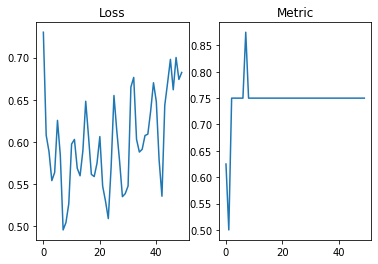

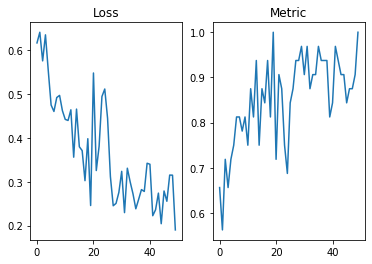

In [14]:
val_monitor.plot()
train_monitor.plot()